In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats.mstats import ttest_1samp, gmean


pd.set_option('display.max_rows', 20)

In [2]:
def gs_crit_full(df):
    overfit = np.abs(df.best_train_auc-df.best_val_auc) + np.abs(df.best_train_auc-df.best_test_auc) + \
              np.abs(df.best_train_auc-df.best_test_intra_auc)
    best_perf = 1-df.best_train_auc + 1-df.best_val_auc + 1-df.best_test_intra_auc + \
                1-df.best_test_auc
    
    return overfit + 2*best_perf

def gs_crit_best(df):
    overfit = np.abs(df.best_train_auc-df.best_val_auc)
    best_perf = 1-df.best_val_auc
    
    return overfit + 2*best_perf

def gs_crit_final(df):
    overfit = np.abs(df.train_auc-df.val_auc)
    final_perf = 1-df.val_auc
    
    return overfit + 2*final_perf


def get_model_region(model_path):
    region = model_path.split('/')[-3]
    return region


def preprocess_bdd(bdd):
    bdd['best_crit'] = gs_crit_best(bdd)
    bdd['final_crit'] = gs_crit_final(bdd)
    bdd['min_best_auc'] = bdd[['best_train_auc', 'best_val_auc', 'best_test_intra_auc', 'best_test_auc']].apply(min, axis=1)
    bdd['min_final_auc'] = bdd[['train_auc', 'val_auc', 'test_intra_auc', 'test_auc']].apply(min, axis=1)
    bdd['min_best_intra'] = bdd[['best_train_auc', 'best_val_auc', 'best_test_intra_auc']].apply(min, axis=1)

    # get the region short name
    bdd['region'] = bdd.model_path.map(get_model_region)

    # sort by criterion
    bdd.sort_values(by='best_crit', inplace=True)


def plot_hists(df):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    sns.histplot(df, x='min_best_auc')
    plt.subplot(1,2,2)
    sns.histplot(df, x='min_final_auc')
    plt.show()


def get_pairplot(bdd, best=True):
    keep_cols = ['train_auc', 'val_auc', 'test_intra_auc', 'test_auc', 'final_crit']
    if best:
        for i in range(len(keep_cols)):
            keep_cols[i] = 'best_' + keep_cols[i]
        keep_cols[-1] = 'best_crit'
    
    sns.pairplot(bdd[keep_cols])


def test_gs_crit(bdd, n_models, best=True, metric='test'):
    """Function in order to know if one of the n_models best models for gs_crit 
    has the best perfomance in test auc (or min auc).

    Arguments:
        - bdd:
        - n_models: number of models to consider as the best models
        - best: if True, take the measures for the best perfoming model, else
        - metric: choose if the performance is evaluated on the test auc or on
        the min of all the auc."""
    
    # choose the column to consider
    if metric == 'test':
        if best:
            col_name = 'best_test_auc'
        else:
            col_name = 'test_auc'
    elif metric == 'min':
        if best:
            col_name = 'min_best_auc'
        else:
            col_name = 'min_final_auc'
    else:
        raise ValueError("metric argument should be either 'test" or 'min')

    # get the best value for the metric considered
    best_value = bdd[col_name].max()

    # get the best models according to gs_crit
    if best:
        gs_crit = 'best_crit'
    else:
        gs_crit = 'final_crit'

    best_models = bdd.sort_values(by=gs_crit, ascending=True).iloc[:n_models,:]
    best_models_best_value = best_models[col_name].max()

    if best_value == best_models_best_value:
        return True, best_value, best_models_best_value
    else:
        return False, best_value, best_models_best_value


def get_gs_index(bdd, best=True, metric='test'):
    """Get the gs_crit ranking of the model with the best chosen metric,
    i.e. the number of models you have to include in your 'bests' in order 
    for you to have the best perf for the chosen metric.
    
    Arguments:
        - bdd:
        - best: if True, take the measures for the best perfoming model, else
        - metric: choose if the performance is evaluated on the test auc or on
        the min of all the auc
    """

    # choose the column to consider
    if metric == 'test':
        if best:
            col_name = 'best_test_auc'
        else:
            col_name = 'test_auc'
    elif metric == 'min':
        if best:
            col_name = 'min_best_auc'
        else:
            col_name = 'min_final_auc'
    else:
        raise ValueError("metric argument should be either 'test" or 'min')

    # get the best value for the metric considered
    best_value = bdd[col_name].max()

    # get the best models according to gs_crit
    if best:
        gs_crit = 'best_crit'
    else:
        gs_crit = 'final_crit'

    best_models = bdd.sort_values(by=gs_crit, ascending=True, ignore_index=True)
    best_models_best_value = best_models[best_models[col_name] == best_value].index.values[0] + 1

    return best_models_best_value

def top_5_auc(bdd, best=True, metric='test'):
    """Function in order to know if one of the n_models best models for gs_crit 
    has the best perfomance in test auc (or min auc).

    Arguments:
        - bdd:
        - best: if True, take the measures for the best perfoming model, else
        - metric: choose if the performance is evaluated on the test auc or on
        the min of all the auc."""
    
    # choose the column to consider
    if metric == 'test':
        if best:
            auc = 'best_test_auc'
        else:
            auc = 'test_auc'
    elif metric == 'min':
        if best:
            auc = 'min_best_auc'
        else:
            auc = 'min_final_auc'
    else:
        raise ValueError("metric argument should be either 'test" or 'min')

    # get the best models according to gs_crit
    if best:
        gs_crit = 'best_crit'
    else:
        gs_crit = 'final_crit'

    best_models = bdd.sort_values(by=gs_crit, ascending=True).iloc[:5,:]

    return best_models[auc].mean()

# Tests on one region

On veut :
    
    - le tableau croisé des auc et crit, pour final et best

    - le min des AUC
    
    - check la corrélation entre crit et perf
    
    - regarder quand les best perf sont atteinte en val

    - savoir si le best test (ou min) est atteint dans les 5 meilleurs modèles pour gs_crit

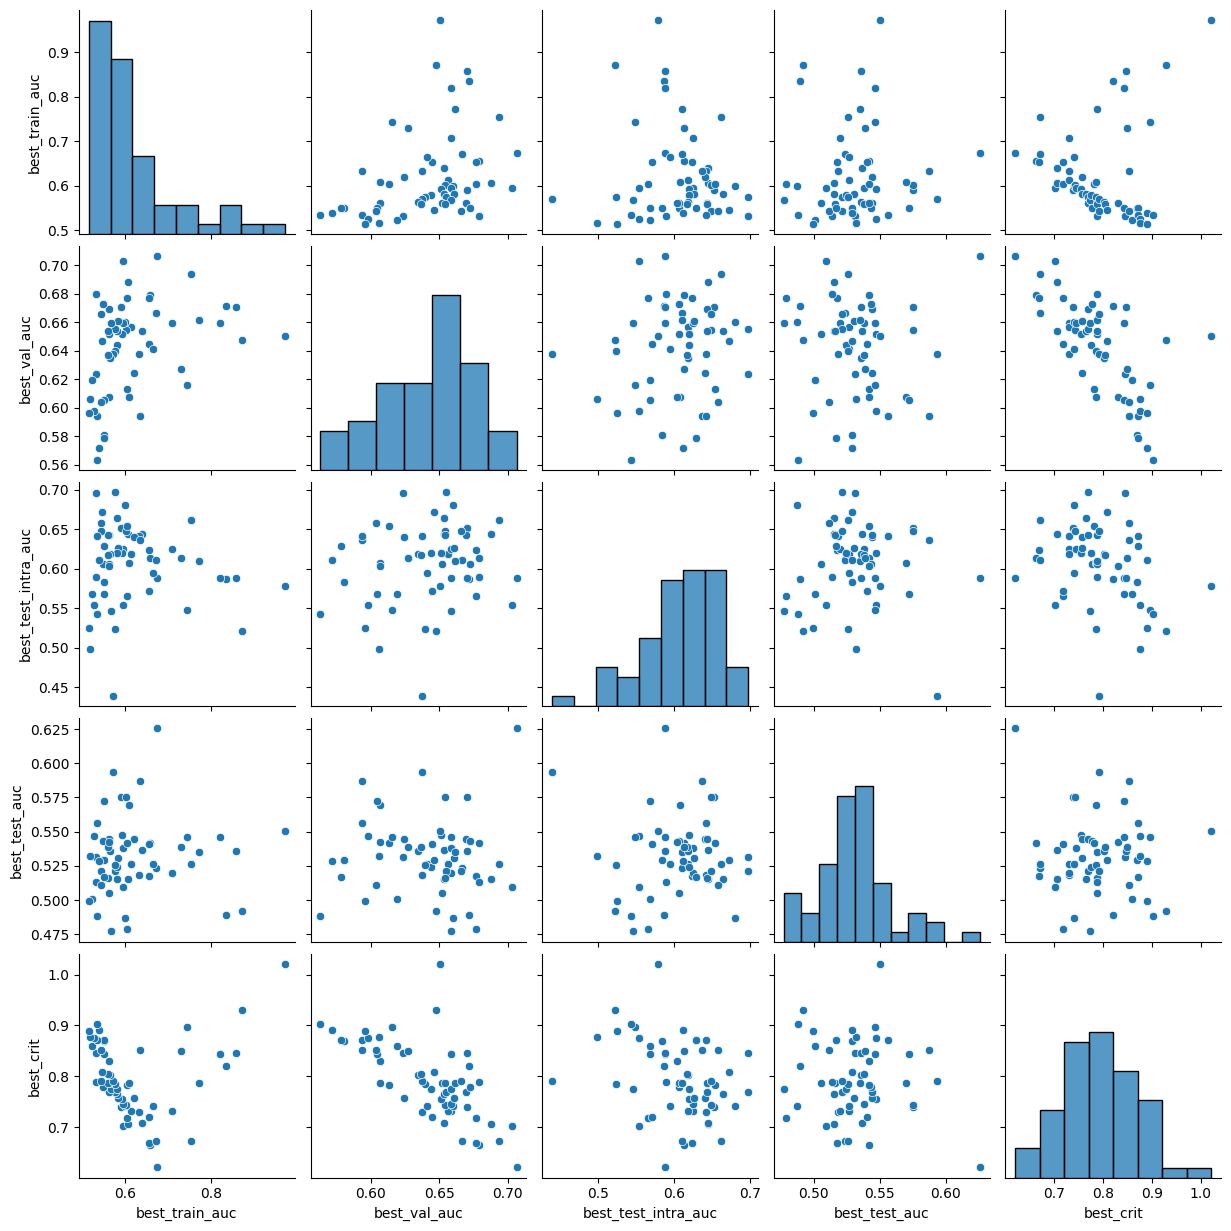

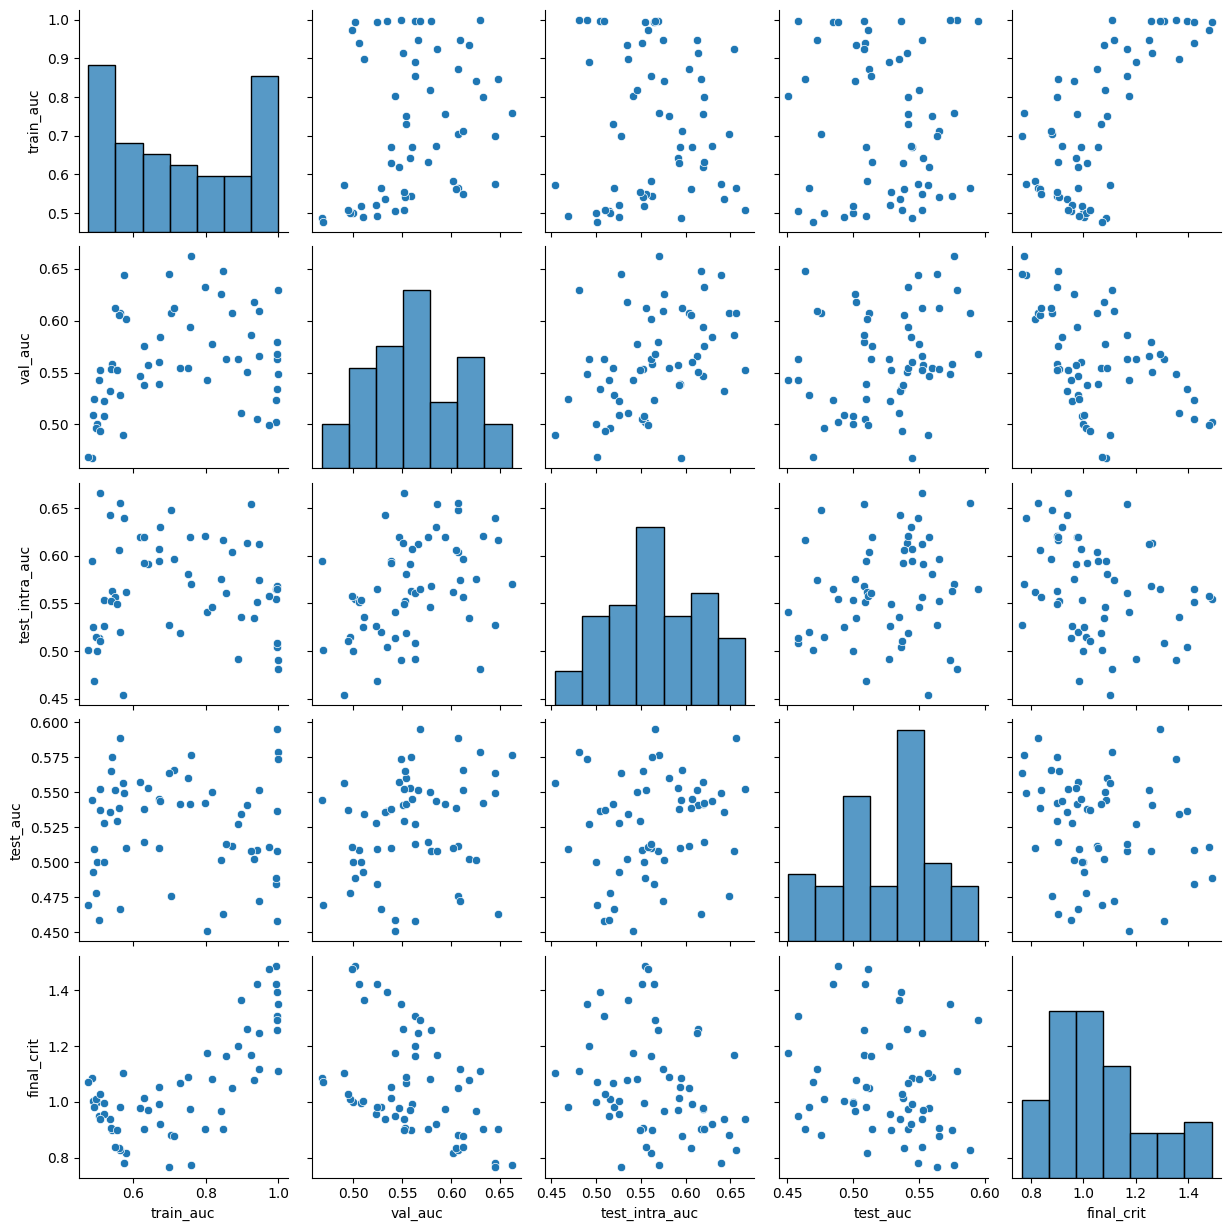

In [12]:
region = 'pericalcarine'

bdd_path = f"/neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step2/{region}/bdd_{region}.csv"

bdd = pd.read_csv(bdd_path, index_col=0)
preprocess_bdd(bdd)

get_pairplot(bdd)
plt.show()
get_pairplot(bdd, best=False)

# Full bdd analysis and visualisation

In [4]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step2/bdd_step2.csv", index_col=0)
preprocess_bdd(bdd)
bdd = bdd.sort_values(by='region', key=lambda col: col.str.lower())
bdd = bdd.dropna()
bdd

,model_path,best_model_epoch,train_auc,val_auc,test_auc,test_intra_auc,best_train_auc,best_val_auc,best_test_auc,best_test_intra_auc,...,max_angle,max_epochs,sigma_noise,train_loss,best_crit,final_crit,min_best_auc,min_final_auc,min_best_intra,region
41,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,2,0.694568,0.491892,0.501359,0.640086,0.620614,0.557173,0.528390,0.553571,...,3,101,0.364696,129.723953,0.949097,1.218893,0.528390,0.491892,0.553571,BROCA
19,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,9,0.698339,0.516840,0.491694,0.585591,0.612390,0.614137,0.558291,0.567426,...,5,101,0.395091,129.547272,0.773473,1.147819,0.558291,0.491694,0.567426,BROCA
5,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0,0.674710,0.528898,0.478556,0.586207,0.621364,0.616216,0.539414,0.525554,...,0,101,0.181160,130.801102,0.772715,1.088016,0.525554,0.478556,0.525554,BROCA
47,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,11,0.642443,0.505613,0.480670,0.548645,0.627874,0.569231,0.508155,0.560345,...,3,101,0.231532,132.962982,0.920182,1.125603,0.508155,0.480670,0.560345,BROCA
35,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,7,0.760501,0.474844,0.506342,0.625000,0.627937,0.583784,0.507551,0.547414,...,5,101,0.574278,124.049408,0.876585,1.335969,0.507551,0.474844,0.547414,BROCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,11,0.449960,0.439085,0.456811,0.470289,0.517269,0.590852,0.527182,0.514470,...,6,101,0.408168,229.455048,0.891879,1.132705,0.514470,0.439085,0.514470,STs_br
568,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,13,0.446158,0.438669,0.454092,0.431650,0.564915,0.575052,0.565388,0.532943,...,5,101,0.365801,148.682022,0.860033,1.130149,0.532943,0.431650,0.532943,STs_br
562,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,42,0.648204,0.549272,0.507400,0.619458,0.661128,0.609563,0.507551,0.511084,...,0,101,0.490526,134.998901,0.832438,1.000387,0.507551,0.507400,0.511084,STs_br
573,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,18,0.535591,0.543035,0.531561,0.608990,0.593802,0.592100,0.589625,0.587131,...,6,101,0.140388,135.130066,0.817503,0.921374,0.587131,0.531561,0.587131,STs_br


## Best_model_epoch

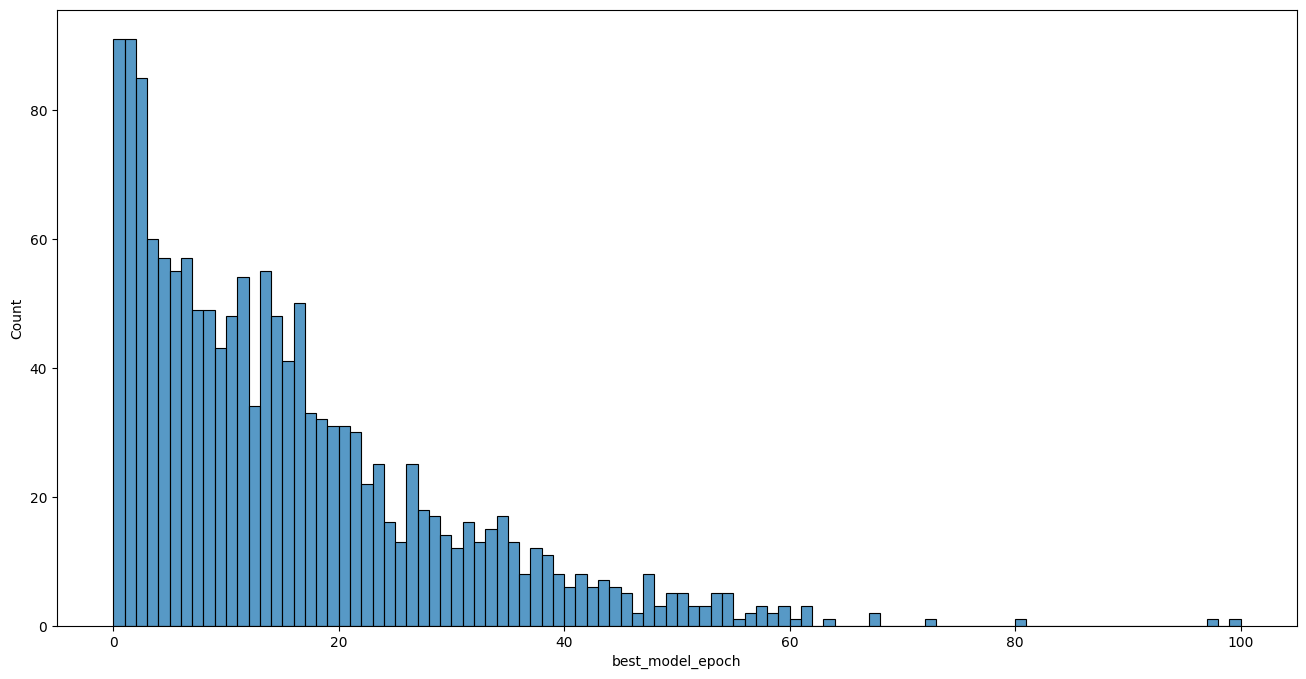

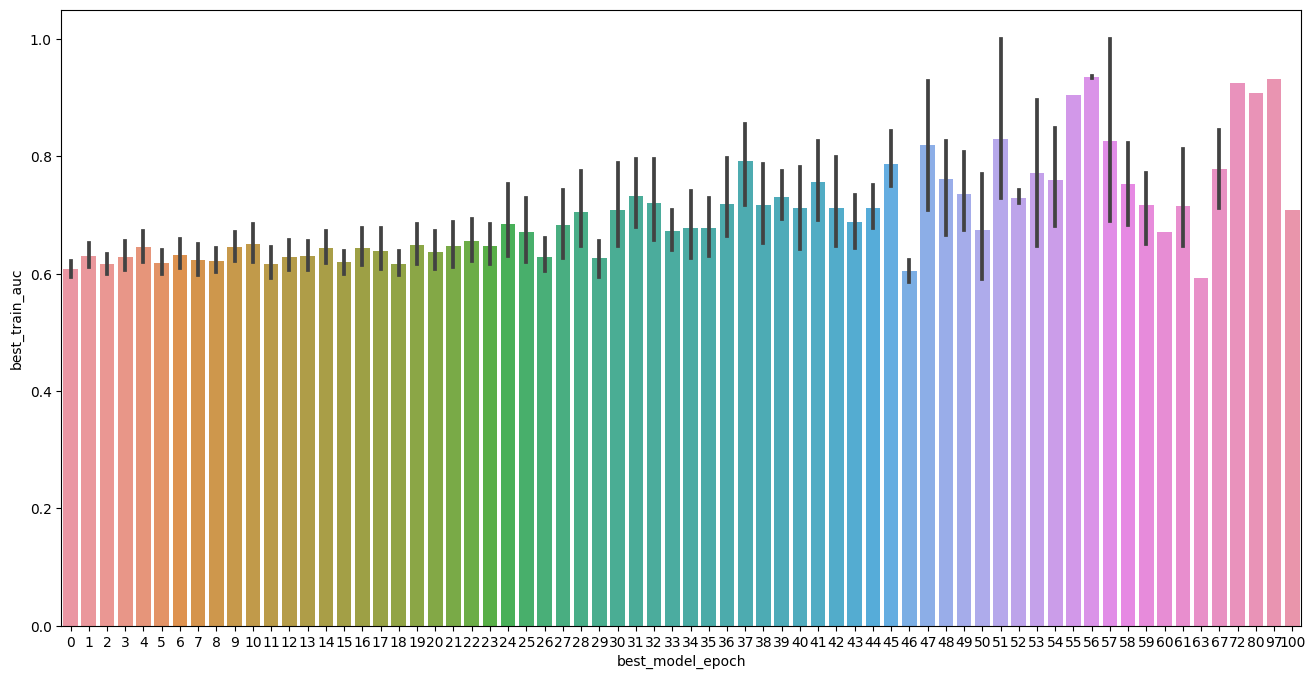

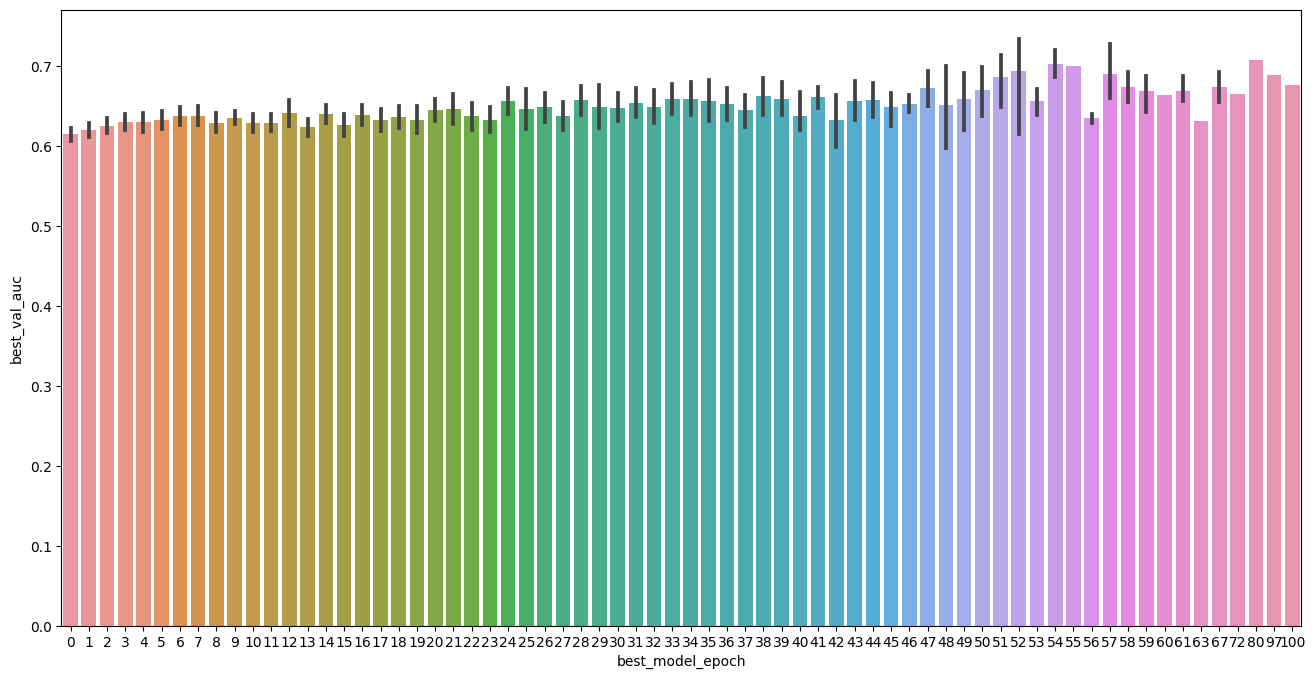

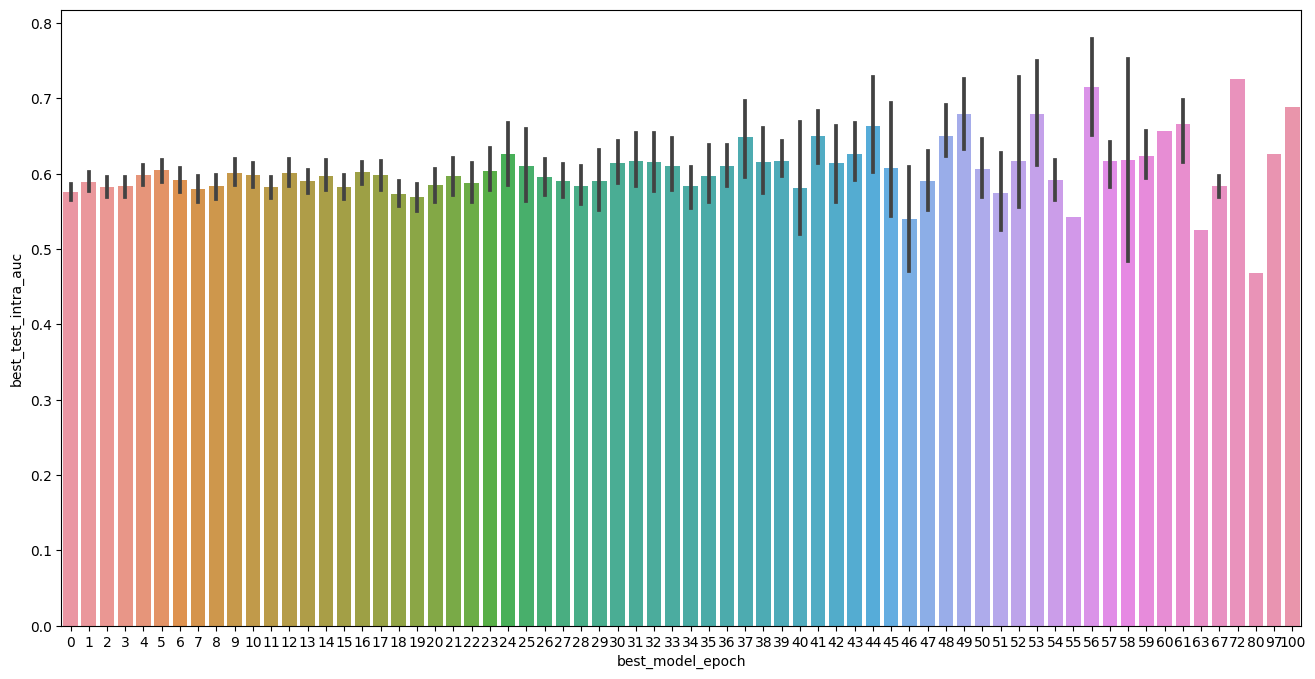

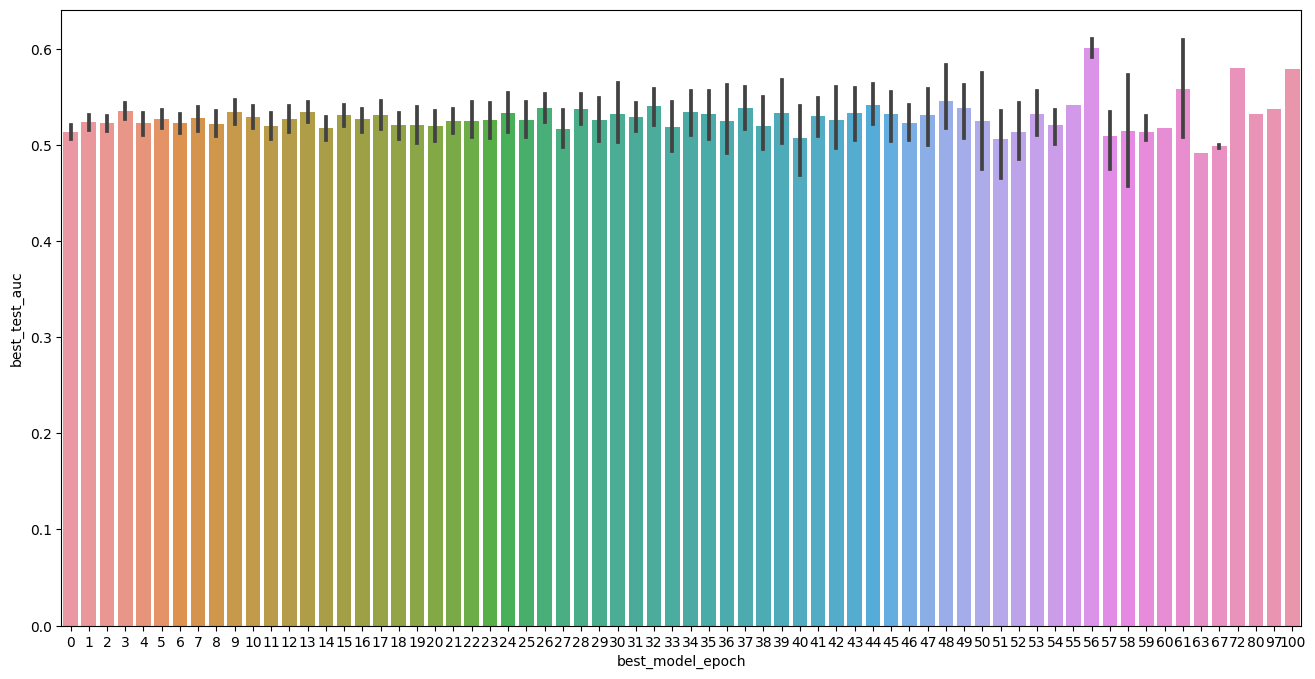

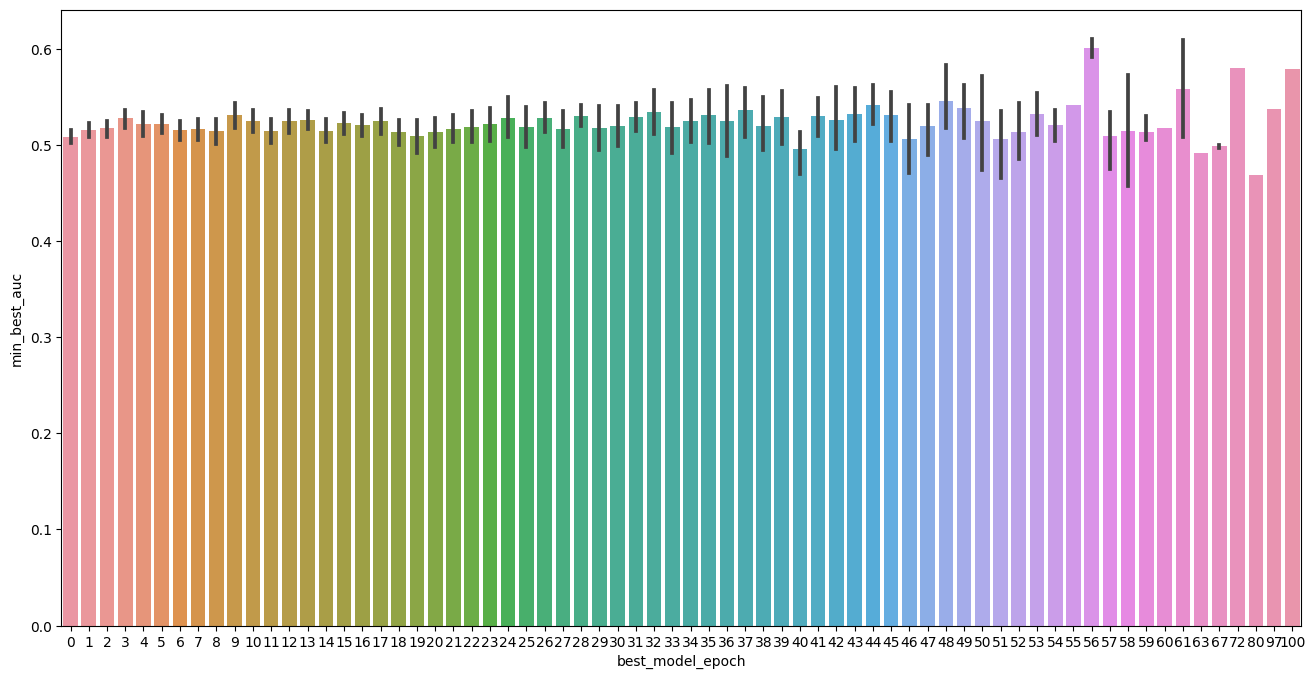

In [16]:
plt.figure(figsize=(16,8))
sns.histplot(bdd, x='best_model_epoch', bins=range(0,101))
plt.show()

plt.figure(figsize=(16,8))
sns.barplot(bdd, x='best_model_epoch', y='best_train_auc')
plt.show()

plt.figure(figsize=(16,8))
sns.barplot(bdd, x='best_model_epoch', y='best_val_auc')
plt.show()

plt.figure(figsize=(16,8))
sns.barplot(bdd, x='best_model_epoch', y='best_test_intra_auc')
plt.show()

plt.figure(figsize=(16,8))
sns.barplot(bdd, x='best_model_epoch', y='best_test_auc')
plt.show()

plt.figure(figsize=(16,8))
sns.barplot(bdd, x='best_model_epoch', y='min_best_auc')
plt.show()

## Mean auc and p value visu

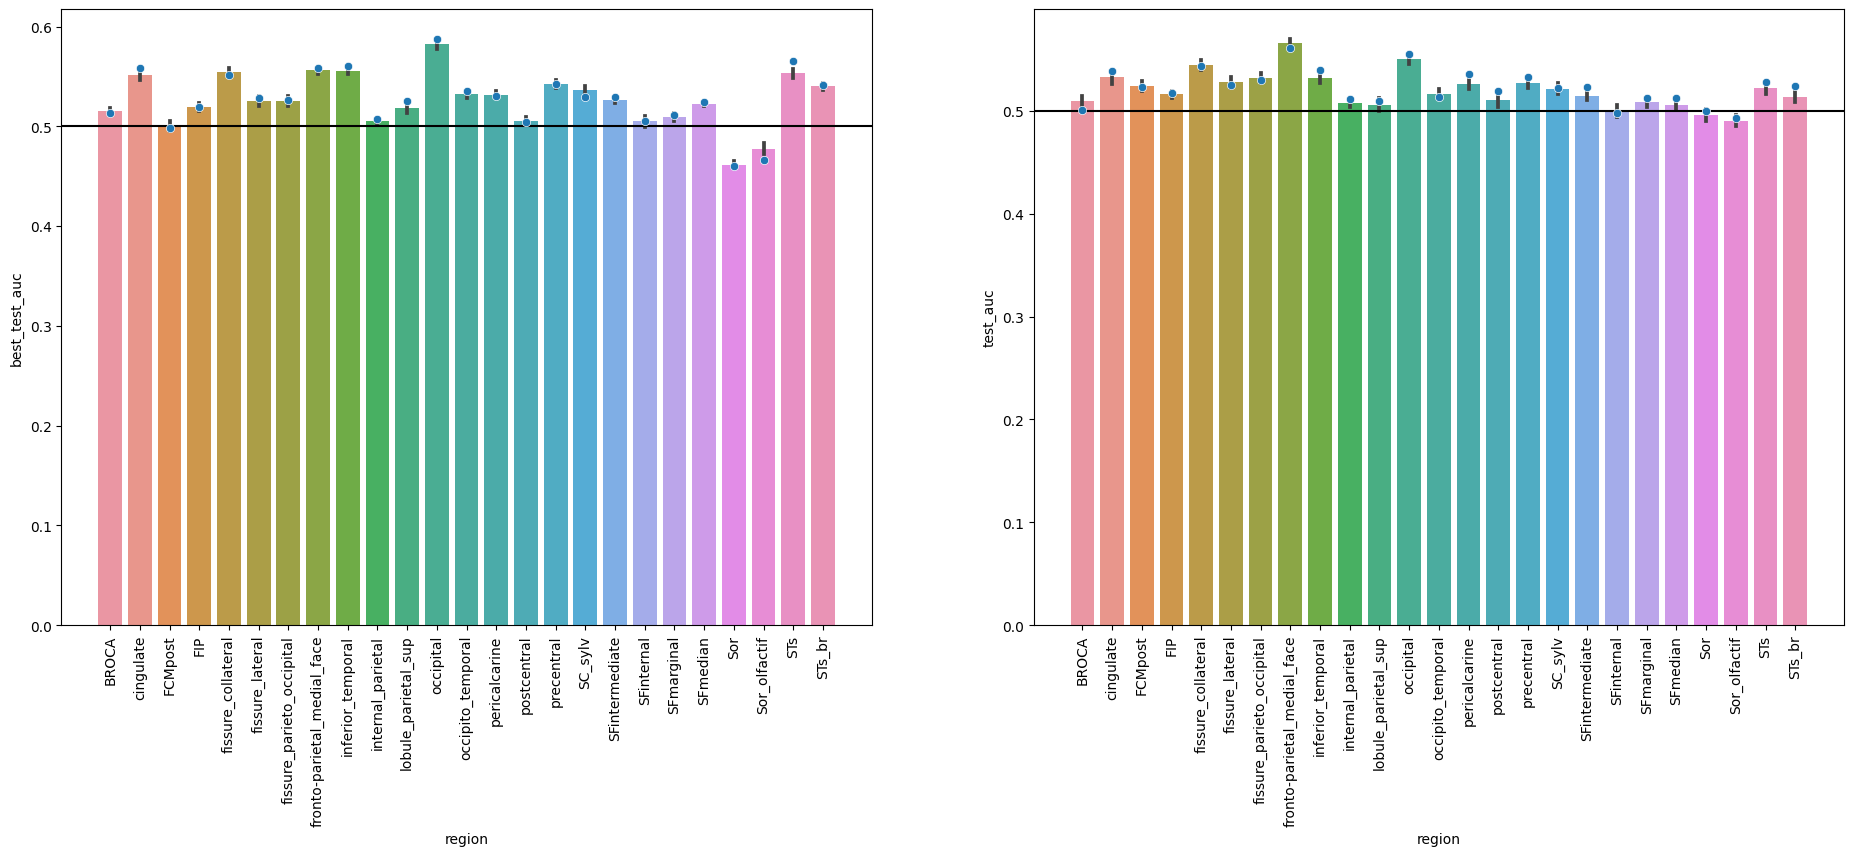

In [17]:
plt.figure(figsize=(23,8))

plt.subplot(1,2,1)
sns.barplot(bdd, x='region', y='best_test_auc', errorbar='se')
plt.xticks(rotation=90)
plt.axhline(0.5, c='black')
# add median
medians = []
for region in bdd.region.unique():
    # print(region) # check if regions are in the same order
    medians.append(bdd[bdd.region == region].best_test_auc.median())
sns.scatterplot(x=bdd.region.unique(), y=medians, zorder=25)


plt.subplot(1,2,2)
sns.barplot(bdd, x='region', y='test_auc', errorbar='se')
plt.xticks(rotation=90)
plt.axhline(0.5, c='black')
# add median
medians = []
for region in bdd.region.unique():
    medians.append(bdd[bdd.region == region].test_auc.median())
sns.scatterplot(x=bdd.region.unique(), y=medians, zorder=25)

"""plt.subplot(2,2,2)
sns.barplot(bdd, x='region', y='min_best_auc')
plt.xticks(rotation=90)

plt.subplot(2,2,4)
sns.barplot(bdd, x='region', y='min_final_auc')
plt.xticks(rotation=90)"""
plt.show()

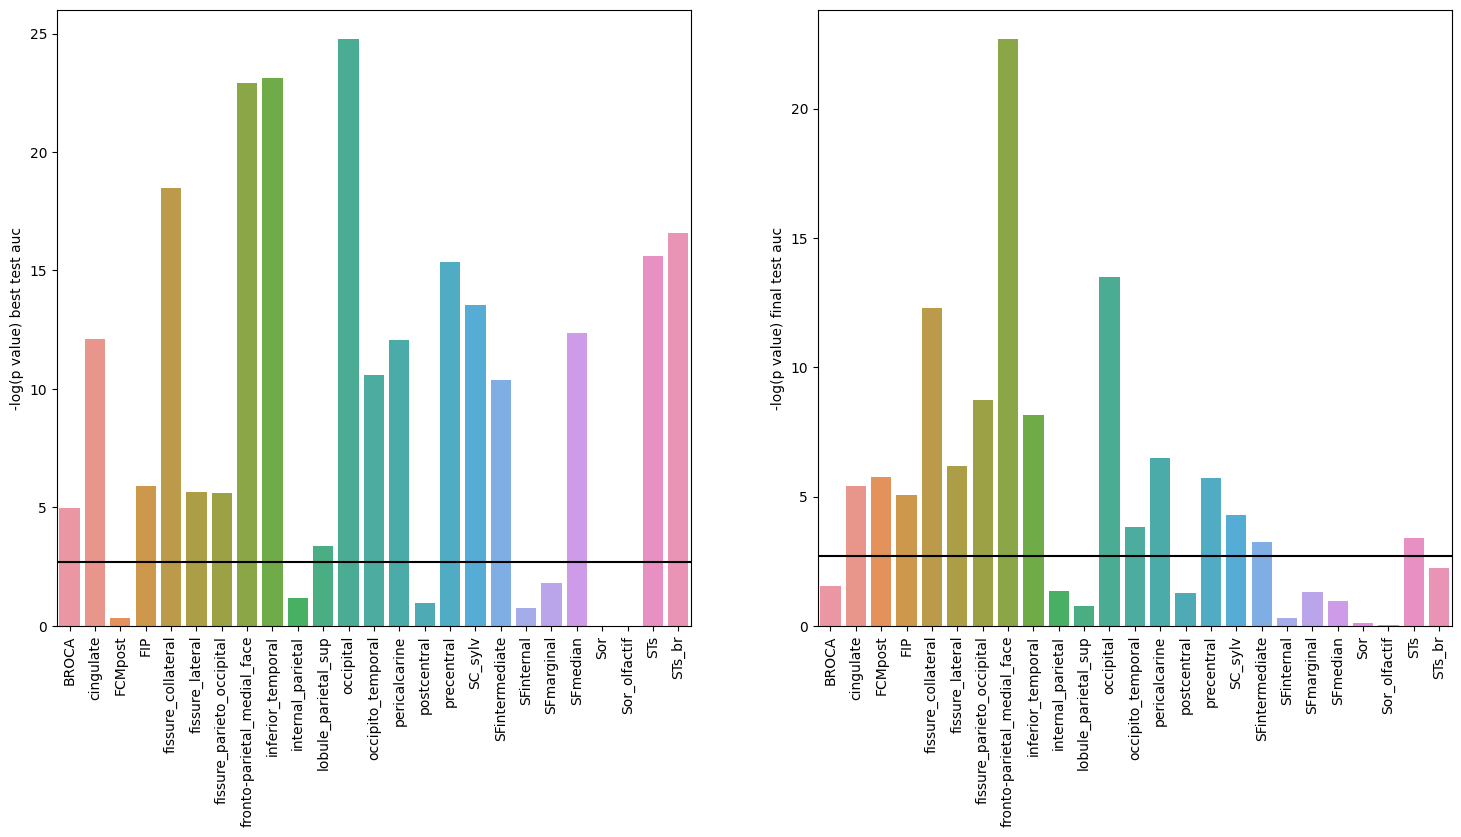

In [6]:
## pvalues

plt.figure(figsize=(18,8))

p_values_best = {}
for region in bdd.region:
    bdd_region = bdd[bdd.region == region]
    _, p = ttest_1samp(bdd_region.best_test_auc, popmean=0.5, alternative='greater')
    p_values_best[region] = -np.log10(p)

plt.subplot(1,2,1)
sns.barplot(x=list(p_values_best.keys()), y=list(p_values_best.values()))
plt.xticks(rotation=90)
plt.axhline(-np.log10(0.05/25), c='black')
plt.ylabel("-log(p value) best test auc")


p_values_final = {}
for region in bdd.region:
    bdd_region = bdd[bdd.region == region]
    _, p = ttest_1samp(bdd_region.test_auc, popmean=0.5, alternative='greater')
    p_values_final[region] = -np.log10(p)

plt.subplot(1,2,2)
sns.barplot(x=list(p_values_final.keys()), y=list(p_values_final.values()))
plt.xticks(rotation=90)
plt.axhline(-np.log10(0.05/25), c='black')
plt.ylabel("-log(p value) final test auc")

plt.show()

### Top 5 models for gs crit

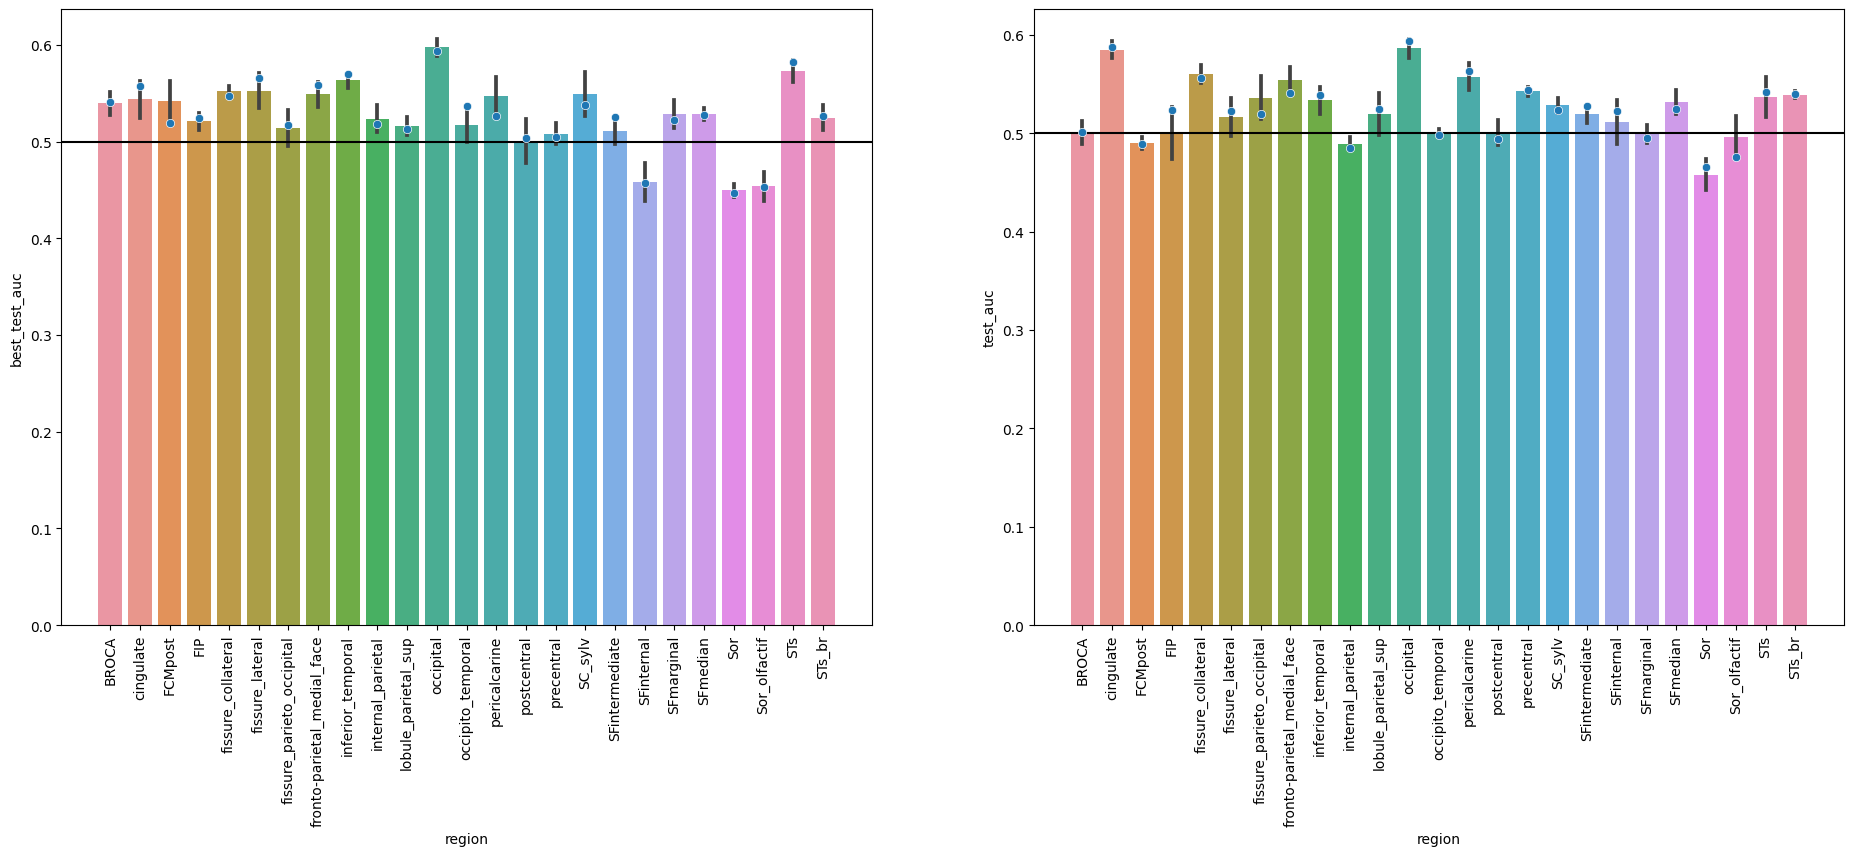

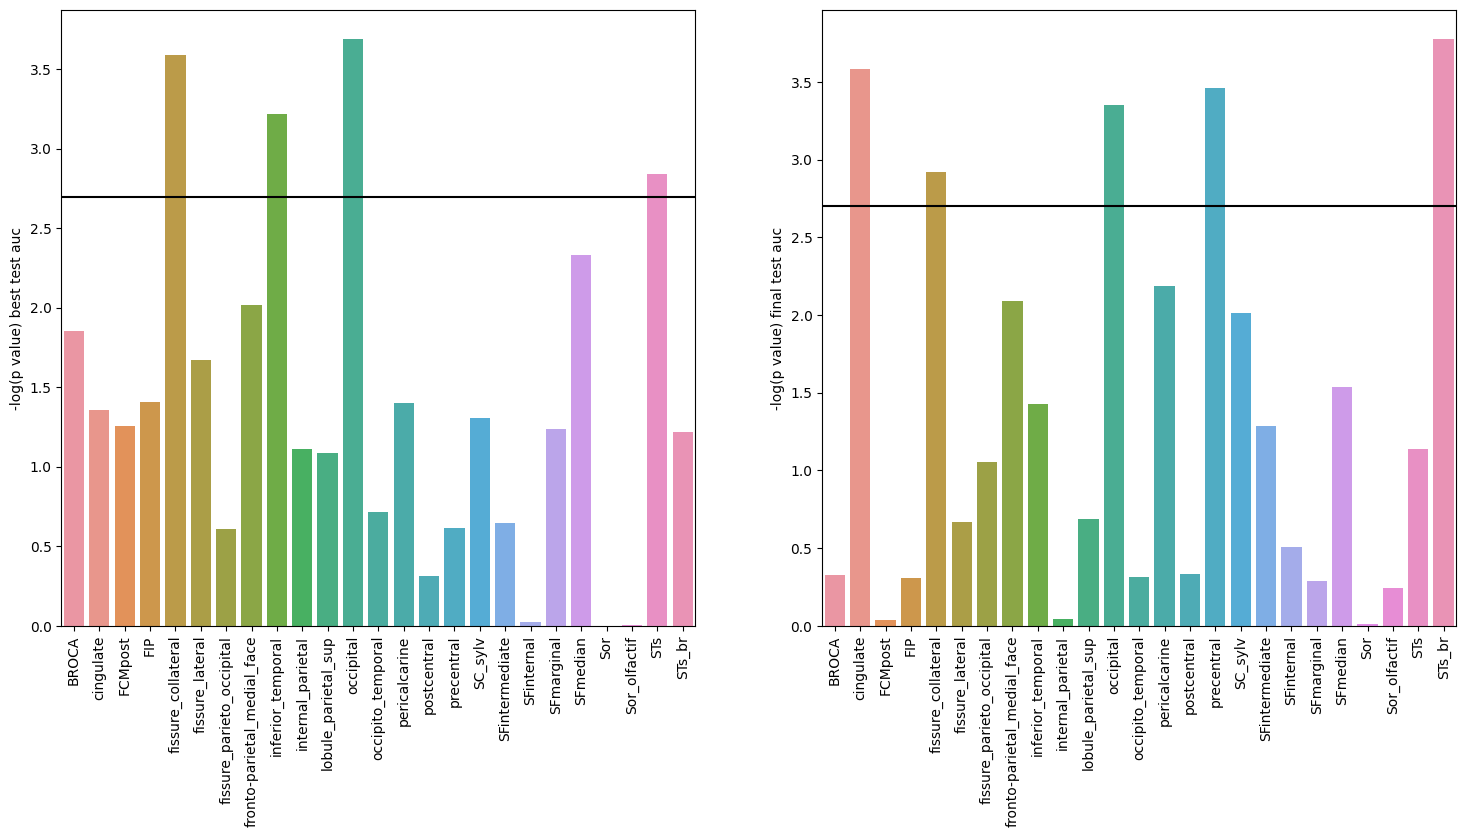

In [20]:
best_gs_models = bdd.sort_values(by='best_crit').groupby('region').head(5).sort_values(by='region', key=lambda col: col.str.lower())
final_gs_models = bdd.sort_values(by='final_crit').groupby('region').head(5).sort_values(by='region', key=lambda col: col.str.lower())

plt.figure(figsize=(23,8))

plt.subplot(1,2,1)
sns.barplot(best_gs_models, x='region', y='best_test_auc', errorbar='se')
plt.xticks(rotation=90)
plt.axhline(0.5, c='black')
# add median
medians = []
for region in best_gs_models.region.unique():
    # print(region) # check if regions are in the same order
    medians.append(best_gs_models[best_gs_models.region == region].best_test_auc.median())
sns.scatterplot(x=best_gs_models.region.unique(), y=medians, zorder=25)


plt.subplot(1,2,2)
sns.barplot(final_gs_models, x='region', y='test_auc', errorbar='se')
plt.xticks(rotation=90)
plt.axhline(0.5, c='black')
# add median
medians = []
for region in final_gs_models.region.unique():
    # print(region) # check if regions are in the same order
    medians.append(final_gs_models[final_gs_models.region == region].test_auc.median())
sns.scatterplot(x=final_gs_models.region.unique(), y=medians, zorder=25)



## pvalues

plt.figure(figsize=(18,8))

top5_p_values_best = {}
for region in best_gs_models.region:
    bdd_region = best_gs_models[best_gs_models.region == region]
    _, p = ttest_1samp(bdd_region.best_test_auc, popmean=0.5, alternative='greater')
    top5_p_values_best[region] = -np.log10(p)

plt.subplot(1,2,1)
sns.barplot(x=list(top5_p_values_best.keys()), y=list(top5_p_values_best.values()))
plt.xticks(rotation=90)
plt.axhline(-np.log10(0.05/25), c='black')
plt.ylabel("-log(p value) best test auc")


top5_p_values_final = {}
for region in final_gs_models.region:
    bdd_region = final_gs_models[final_gs_models.region == region]
    _, p = ttest_1samp(bdd_region.test_auc, popmean=0.5, alternative='greater')
    top5_p_values_final[region] = -np.log10(p)

plt.subplot(1,2,2)
sns.barplot(x=list(top5_p_values_final.keys()), y=list(top5_p_values_final.values()))
plt.xticks(rotation=90)
plt.axhline(-np.log10(0.05/25), c='black')
plt.ylabel("-log(p value) final test auc")

plt.show()

plt.show()

# Create the df to store the results

In [7]:
res_df = pd.DataFrame()

# add full name region
with open("/neurospin/dico/data/deep_folding/current/short_names.json", 'r') as file:
    regions_names = json.load(file)

my_region_names = {value[-1]: key for key, value in regions_names.items()}
del my_region_names['None']

res_df['full_name'] = my_region_names


# compute values
res_df['test_auc'] = bdd.groupby('region').test_auc.mean()
res_df['best_test_auc'] = bdd.groupby('region').best_test_auc.mean()
res_df['test_auc_se'] = bdd.groupby('region').test_auc.sem()
res_df['best_test_auc_se'] = bdd.groupby('region').best_test_auc.sem()
res_df['-log_p_value_best'] = pd.Series(p_values_best)
res_df['-log_p_value_final'] = pd.Series(p_values_final)

res_df['top5_test_auc'] = final_gs_models.groupby('region').test_auc.mean()
res_df['top5_best_test_auc'] = best_gs_models.groupby('region').best_test_auc.mean()
res_df['top5_test_auc_se'] = final_gs_models.groupby('region').test_auc.sem()
res_df['top5_best_test_auc_se'] = best_gs_models.groupby('region').best_test_auc.sem()
res_df['top5_-log_p_value_best'] = pd.Series(top5_p_values_best)
res_df['top5_-log_p_value_final'] = pd.Series(top5_p_values_final)

# These results are saved at /neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step2/schiz_stats_by_region.csv

res_df

NameError: name 'final_gs_models' is not defined

In [16]:
res_df = pd.read_csv("/neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step2/schiz_stats_by_region.csv", index_col=0)
res_df = res_df.sort_index(key=lambda col: col.str.lower())
res_df

,full_name,test_auc,best_test_auc,test_auc_se,best_test_auc_se,-log_p_value_best,-log_p_value_final,top5_test_auc,top5_best_test_auc,top5_test_auc_se,top5_best_test_auc_se,top5_-log_p_value_best,top5_-log_p_value_final
BROCA,S.F.inf.-BROCA-S.Pe.C.inf.,0.509573,0.515282,0.004978,0.003315,4.957421e+00,1.527788,0.500891,0.539656,0.011979,0.011790,1.850623,0.325930
cingulate,CINGULATE.,0.532325,0.551791,0.006604,0.005809,1.210309e+01,5.399155,0.585110,0.543461,0.008360,0.019361,1.355780,3.581346
FCMpost,F.C.M.post.-S.p.C.,0.524086,0.500535,0.004715,0.005186,3.380849e-01,5.736718,0.490245,0.542162,0.005707,0.020649,1.256872,0.036816
FIP,F.I.P.,0.515996,0.519511,0.003429,0.003746,5.895990e+00,5.041326,0.500302,0.520749,0.026287,0.008831,1.405808,0.304789
fissure_collateral,F.Coll.-S.Rh.,0.544440,0.554309,0.004925,0.004192,1.847850e+01,12.282892,0.560465,0.552280,0.008853,0.005111,3.589271,2.920136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SFmedian,S.F.median-S.F.pol.tr.-S.F.sup.,0.505926,0.522583,0.004797,0.002489,1.236222e+01,0.955374,0.532045,0.528209,0.012196,0.006005,2.331341,1.535103
Sor,S.or.,0.495816,0.461522,0.005502,0.003772,2.603684e-15,0.110689,0.458124,0.449381,0.015347,0.006541,0.000326,0.011556
Sor_olfactif,S.or.-S.Olf.,0.490450,0.477443,0.005483,0.005369,1.974030e-05,0.019265,0.496074,0.453519,0.021415,0.014674,0.007432,0.245441
STs,S.T.s.,0.522412,0.553065,0.006333,0.004731,1.562726e+01,3.394259,0.537043,0.572788,0.020517,0.011215,2.837745,1.138738


## Manhattan plot

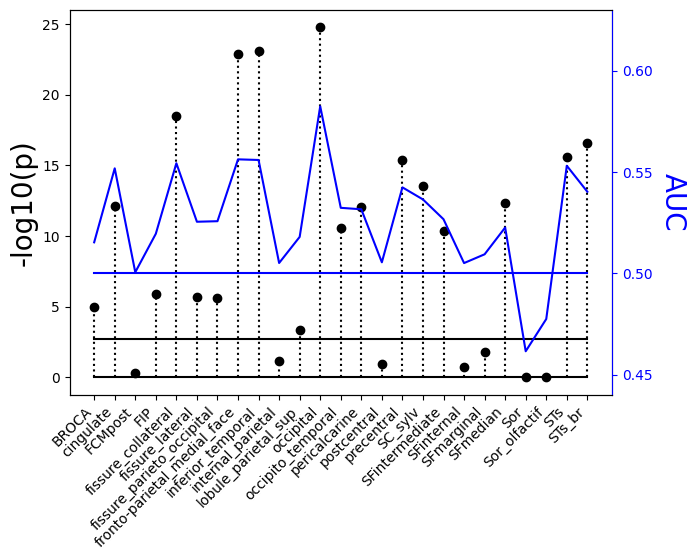

In [28]:
def plot_manhattan(res, ax, AUC_name, logp_AUC_name):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res["p_value_line"] = -np.log10(0.05/25)
    res["auc_line"] = 0.5
    markerline, stemlines, baseline = \
        ax.stem(res.index,
              res[logp_AUC_name],
              basefmt= 'C0',
              linefmt=':')
    plt.setp(markerline, 'color', 'black')
    plt.setp(stemlines, 'color', 'black')
    plt.setp(baseline, 'color', 'black')
    plt.xticks(rotation=45, ha="right")
    ax.plot(res.index, res.p_value_line, c='black')
    ax.set_ylabel("-log10(p)", labelpad=3.0)
    # ax.set_xlabel("regions", labelpad=10.0)
    ax2 = ax.twinx()
    ax2.xaxis.set_tick_params(labelsize = labelsize)
    ax2.yaxis.set_tick_params(labelsize = labelsize)
    ax2.plot(res.index, res[AUC_name], c='blue')
    ax2.plot(res.index, res.auc_line, c='blue')
    ax2.set_ylim([0.44,0.63])
    ax2.set_ylabel('AUC', color='b', rotation=270, labelpad=25)
    ax2.set_yticks([0.45, 0.5, 0.55, 0.6])
    ax2.spines['right'].set_color('blue')
    ax2.tick_params(axis='y', colors='blue')


plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res_df, ax, "best_test_auc", "-log_p_value_best")
plt.savefig("/neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step2/manhattan_regions.svg", format='svg', bbox_inches='tight')
plt.show()

In [23]:
res_df.loc['inferior_temporal',:]

full_name                  S.T.i.-S.T.s.-S.T.pol.
test_auc                                 0.532042
best_test_auc                            0.555918
test_auc_se                              0.004873
best_test_auc_se                         0.003426
-log_p_value_best                        23.12369
-log_p_value_final                       8.151204
top5_test_auc                            0.533479
top5_best_test_auc                       0.563183
top5_test_auc_se                         0.013954
top5_best_test_auc_se                    0.007705
top5_-log_p_value_best                   3.220116
top5_-log_p_value_final                  1.429348
Name: inferior_temporal, dtype: object

PearsonRResult(statistic=0.8166412964335589, pvalue=6.391126095229639e-07)


<Axes: xlabel='top5_best_test_auc', ylabel='best_test_auc'>

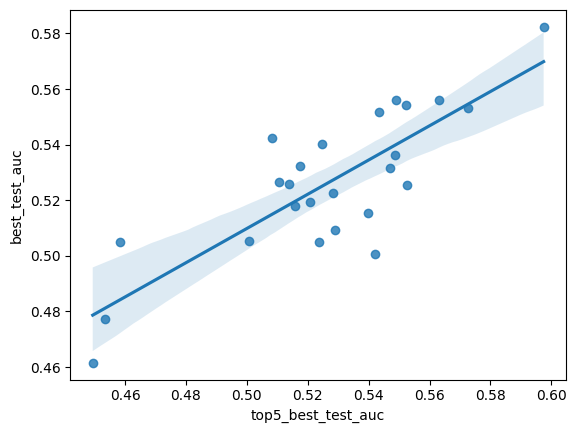

In [27]:
x = "top5_best_test_auc"
y = 'best_test_auc'
print(pearsonr(res_df[x], res_df[y]))
sns.regplot(res_df, x=x, y=y)

# Region size and perf

In [50]:
# get the size of all regions

regions_path = '/neurospin/dico/data/deep_folding/current/datasets/schiz/crops/2mm'
size_dict = {}

for region in os.listdir(regions_path):
    print(region)
    size_dict[region] = []
    path = os.path.join(regions_path, region, 'mask')
    L_numpy = np.load(os.path.join(path, 'Lskeleton.npy'))
    size_dict[region].append(L_numpy.shape[1:-1])
    R_numpy = np.load(os.path.join(path, 'Rskeleton.npy'))
    size_dict[region].append(R_numpy.shape[1:-1])

size_dict

S.or.
F.Coll.-S.Rh.
S.F.median-S.F.pol.tr.-S.F.sup.
S.F.inf.-BROCA-S.Pe.C.inf.
S.T.i.
S.C.
fronto-parietal_medial_face.
F.I.P.
S.C.-S.Po.C.
S.or.-S.Olf.
S.F.inter.-S.F.sup.
F.C.M.post.-S.p.C.
S.s.P.-S.Pa.int.
F.P.O.-S.Cu.-Sc.Cal.
S.F.marginal-S.F.inf.ant.
CINGULATE
S.T.i.-S.T.s.-S.T.pol.
S.F.int.-S.R.
Lobule_parietal_sup.
S.T.i.-S.O.T.lat.
frontal.
S.T.s.br.
S.T.s.branches.
Sc.Cal.-S.Li.
S.T.s.
F.C.L.p.-subsc.-F.C.L.a.-INSULA.
S.C.-sylv.
S.C.-S.Pe.C.
OCCIPITAL


{'S.or.': [(30, 38, 22), (26, 34, 23)],
 'F.Coll.-S.Rh.': [(29, 62, 36), (34, 62, 41)],
 'S.F.median-S.F.pol.tr.-S.F.sup.': [(31, 54, 58), (30, 52, 55)],
 'S.F.inf.-BROCA-S.Pe.C.inf.': [(25, 41, 44), (26, 40, 43)],
 'S.T.i.': [(27, 62, 50), (26, 57, 48)],
 'S.C.': [(38, 35, 47), (42, 34, 48)],
 'fronto-parietal_medial_face.': [(27, 93, 61), (24, 82, 58)],
 'F.I.P.': [(41, 53, 44), (39, 54, 45)],
 'S.C.-S.Po.C.': [(40, 44, 49), (42, 43, 49)],
 'S.or.-S.Olf.': [(31, 41, 23), (31, 38, 24)],
 'S.F.inter.-S.F.sup.': [(30, 51, 50), (31, 50, 53)],
 'F.C.M.post.-S.p.C.': [(16, 45, 31), (17, 47, 31)],
 'S.s.P.-S.Pa.int.': [(27, 43, 56), (23, 34, 43)],
 'F.P.O.-S.Cu.-Sc.Cal.': [(25, 42, 54), (26, 42, 55)],
 'S.F.marginal-S.F.inf.ant.': [(34, 32, 39), (36, 32, 39)],
 'CINGULATE': [(18, 41, 38), (17, 40, 38)],
 'S.T.i.-S.T.s.-S.T.pol.': [(34, 67, 57), (33, 63, 56)],
 'S.F.int.-S.R.': [(16, 55, 58), (17, 57, 59)],
 'Lobule_parietal_sup.': [(40, 47, 46), (41, 45, 48)],
 'S.T.i.-S.O.T.lat.': [(34, 64

In [66]:
def get_mean_size(size_left, size_right):
    mean_left = gmean(size_left)
    mean_right = gmean(size_right)
    return (mean_left + mean_right)/2

def get_volume(size_left, size_right):
    volume_left = np.prod(size_left)
    volume_right = np.prod(size_right)
    return volume_left + volume_right

sizes = {}
volumes = {}

for region in size_dict.keys():
    sizes[region] = get_mean_size(*size_dict[region])
    volumes[region] = get_volume(*size_dict[region])

sizes['CINGULATE.'] = sizes['CINGULATE']
volumes['CINGULATE.'] = volumes['CINGULATE']

sizes

{'S.or.': 28.282442060989887,
 'F.Coll.-S.Rh.': 42.182124134146534,
 'S.F.median-S.F.pol.tr.-S.F.sup.': 45.03366825331682,
 'S.F.inf.-BROCA-S.Pe.C.inf.': 35.5451339061355,
 'S.T.i.': 42.58879586492215,
 'S.C.': 40.306124454214455,
 'fronto-parietal_medial_face.': 51.00660700413239,
 'F.I.P.': 45.65948610084903,
 'S.C.-S.Po.C.': 44.37187466095087,
 'S.or.-S.Olf.': 30.634565567551025,
 'S.F.inter.-S.F.sup.': 42.96110660291778,
 'F.C.M.post.-S.p.C.': 28.652717575888246,
 'S.s.P.-S.Pa.int.': 36.24372519491436,
 'F.P.O.-S.Cu.-Sc.Cal.': 38.78954828633971,
 'S.F.marginal-S.F.inf.ant.': 35.21449551734797,
 'CINGULATE': 29.972926893965905,
 'S.T.i.-S.T.s.-S.T.pol.': 49.73364857489942,
 'S.F.int.-S.R.': 37.80872415168611,
 'Lobule_parietal_sup.': 44.39788569217539,
 'S.T.i.-S.O.T.lat.': 48.32739412562748,
 'frontal.': 49.08598667721921,
 'S.T.s.br.': 35.858781561462216,
 'S.T.s.branches.': 34.01676996440773,
 'Sc.Cal.-S.Li.': 34.957595110283165,
 'S.T.s.': 40.44629766996983,
 'F.C.L.p.-subsc.-F.

PearsonRResult(statistic=0.5429542481564528, pvalue=0.005038281005378507)


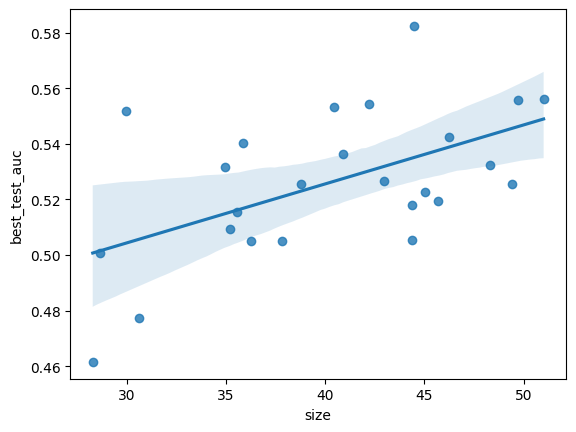

PearsonRResult(statistic=0.5182781787154885, pvalue=0.007952842532513682)


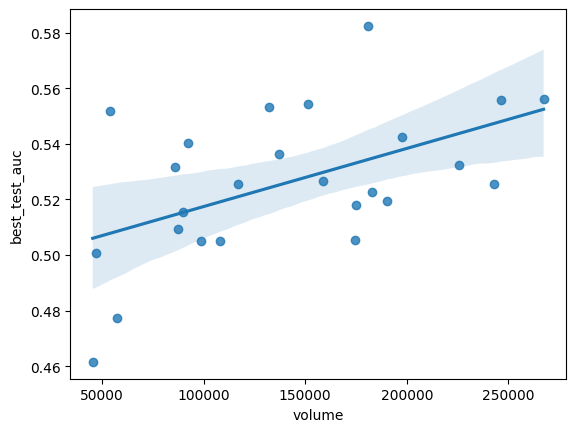

In [52]:
new_res_df = res_df.set_index('full_name')
new_res_df['size'] = sizes
new_res_df['volume'] = volumes

y = 'best_test_auc'

print(pearsonr(new_res_df['size'], new_res_df[y]))
sns.regplot(new_res_df, x='size', y=y)
plt.show()

print(pearsonr(new_res_df['volume'], new_res_df[y]))
sns.regplot(new_res_df, x='volume', y=y)
plt.show()

## frontal region

PearsonRResult(statistic=0.5086369270057618, pvalue=0.007969105985513867)


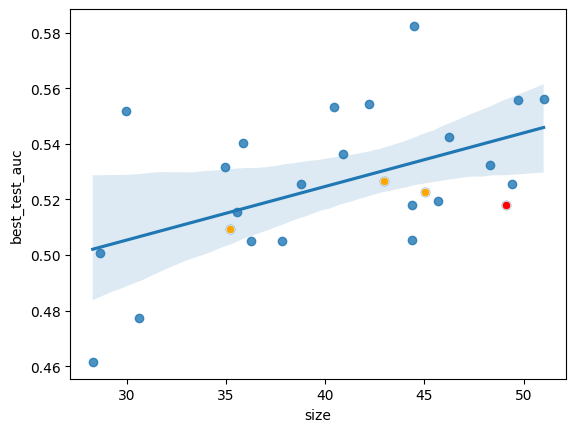

In [68]:
bdd_frontal = pd.read_csv("/neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step3/frontal/bdd_frontal.csv", index_col=0)

new_res_df.loc['frontal.', "size"] = sizes['frontal.']
new_res_df.loc['frontal.', 'best_test_auc'] = bdd_frontal.best_test_auc.mean()

y = 'best_test_auc'

big_region = new_res_df.loc[['frontal.'],:]
small_regions = new_res_df.loc[['S.F.inter.-S.F.sup.','S.F.marginal-S.F.inf.ant.', 'S.F.median-S.F.pol.tr.-S.F.sup.'],:]

print(pearsonr(new_res_df['size'], new_res_df[y]))
sns.regplot(new_res_df, x='size', y=y)
sns.scatterplot(small_regions, x='size', y=y, color='orange')
sns.scatterplot(big_region, x='size', y=y, color='red')
plt.show()

PearsonRResult(statistic=0.5086369270057618, pvalue=0.007969105985513867)


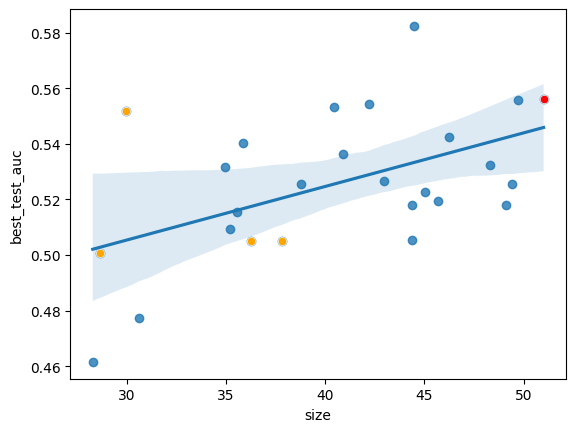

In [67]:
bdd_frontal = pd.read_csv("/neurospin/dico/agaudin/Runs/09_new_repo/Output/grid_searches/step3/frontal/bdd_frontal.csv", index_col=0)

y = 'best_test_auc'

big_region = new_res_df.loc[['fronto-parietal_medial_face.'],:]
small_regions = new_res_df.loc[['CINGULATE.','F.C.M.post.-S.p.C.', 'S.s.P.-S.Pa.int.', 'S.F.int.-S.R.'],:]

print(pearsonr(new_res_df['size'], new_res_df[y]))
sns.regplot(new_res_df, x='size', y=y)
sns.scatterplot(small_regions, x='size', y=y, color='orange')
sns.scatterplot(big_region, x='size', y=y, color='red')
plt.show()